In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import pandas as pd
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [3]:
from src.dataloader import *
from src.models import *
from src.trainer import *
from src.utils import *

In [4]:
DATADRIVE = '/datadrive_ssd/'

In [5]:
interval=0.75
cat_bins = np.arange(0, interval*128, interval)
len(cat_bins), max(cat_bins)

(128, 95.25)

## Load data

In [6]:
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation', 'u_component_of_wind500', 'v_component_of_wind500'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
    const_fn=f'{DATADRIVE}/tigge/32km/constants.nc',
    const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2019-12'),
    val_days=5,
    cat_bins=cat_bins,
    split='train',
    tp_log=1
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [7]:
ds_valid = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation', 'u_component_of_wind500', 'v_component_of_wind500'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
    const_fn=f'{DATADRIVE}/tigge/32km/constants.nc',
    const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2019-12'),
    val_days=5,
    cat_bins=cat_bins,
    split='valid',
    tp_log=1,
    mins=ds_train.mins,
    maxs=ds_train.maxs
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [8]:
sampler_train = torch.utils.data.WeightedRandomSampler(ds_train.compute_weights(
    threshold=interval
), len(ds_train))
sampler_valid = torch.utils.data.WeightedRandomSampler(ds_valid.compute_weights(
    threshold=interval
), len(ds_valid))

In [9]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=16, sampler=sampler_train)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=16, sampler=sampler_valid)

In [10]:
X, y = next(iter(dl_train))
X.shape, y.shape

(torch.Size([16, 5, 16, 16]), torch.Size([16, 128, 128]))

## Model

In [11]:
ds_train.input_vars

5

In [12]:
gen = Generator(
    nres=3, nf_in=ds_train.input_vars, nf=256, nout=128, activation_out=None, use_noise=False,
    spectral_norm=False, halve_filters_up=False, batch_norm=True
).to(device)

In [13]:
count_parameters(gen)

7393920

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=1e-5)

In [15]:
trainer = Trainer(gen, optimizer, criterion, dl_train, dl_valid)

In [16]:
trainer.fit(6)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/torch/nn/functional.py:2503: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



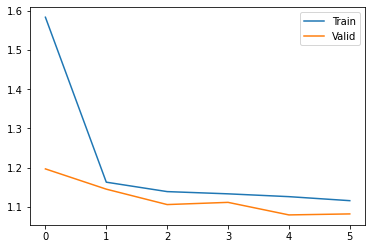

In [17]:
trainer.plot_losses()

In [18]:
import pickle
with open('07.trainer', 'wb') as f:
    pickle.dump(trainer, f)

In [ ]:
import pickle
with open('05.trainer', 'rb') as f:
    trainer = pickle.load(f)

In [ ]:
trainer.plot_losses()

In [67]:
X, y = next(iter(dl_train))

In [68]:
preds = nn.functional.softmax(trainer.model(X.to(device)), dim=1).cpu().detach().numpy()

In [69]:
preds.shape

(16, 128, 128, 128)

In [70]:
target = y.cpu().detach().numpy()

In [71]:
np.argmax(target.mean((1, 2)))

3

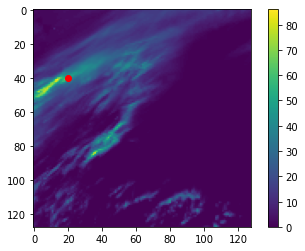

In [124]:
i=7
j, k = 20, 40
plt.imshow(target[i])
plt.colorbar()
plt.scatter(j, k, c='r')

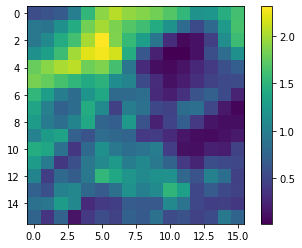

In [125]:
plt.imshow(X[i, 0] * ds_train.maxs.tp.values)
plt.colorbar();

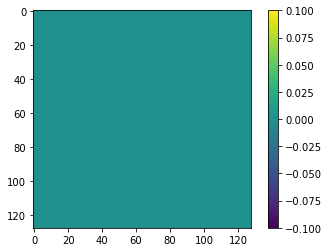

In [126]:
plt.imshow(np.argmax(preds[i], axis=0))
plt.colorbar()

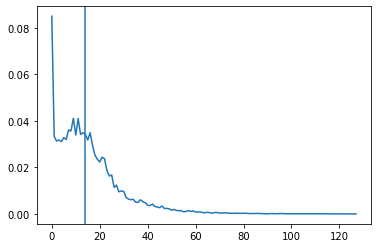

In [127]:
plt.plot(preds[i, :, j, k])
plt.axvline(target[i, j, k])